### When is exact reconstruction possible?
The orignal signal $x_0$ can be recovered exactly by solving the minimization problem:  
$\text{min } \lVert x \rVert_{\ell_1} \text{ subject to } Ax = y$  
such that the measurement matrix $A \in \mathbb{R}^{n\times m}$ obeys the uniform uncertainty principle or the restricted isometry hypothesis.  
The uncertainty principle defined by the paper places a constraint on the how orthogonal the matrix $A$ is, as the paper states that the submatrices of $A$ with cardinality less than the sparsity of the signal $S$ should behave approximately like an orthonormal system. Therefore the matrix A should ideally be as orthogonal as possible.  
Moreover, the paper states that for $|T_0| \leq S$, any sparse signal can be recovered as long as $\delta_S + \delta_{2S} + \delta_{3S} < 1$, where $\delta_S$ is the S-restricted isometry constant.

In [3]:
import numpy as np
import cvxpy as cp
import scipy as sp
import matplotlib.pyplot as plt

For the experiments shown in Figures 2a and 2b, the paper described the measurement matrix $A$ as a "300 × 1024 Gaussian measurement ensemble" in section 3 of the text. 300 is the number of measurements taken from the signal and 1024 is the size of the signal vector. 

In general, the measurement matrix $A$ can be defined by $A \in \mathbb{R}^{n\times m}$ that obeys the uniform uncertainty principle.

Section 1.3 provided several examples of matrices that obey the uniform uncertainty principle, including random matrices with i.i.d. entries where $\mu = 0$ and $\sigma^2=\frac{1}{n}$.   
The paper claims that a gaussian random matrix would obey the uniform uncertainty principle with "overwhelming probability".

Therefore the gaussian random matrix can be defined by the distribution $\mathcal{N}(\mu=0,~\sigma^2=\frac{1}{n})$.
The numpy library was used to generate $A$ with i.i.d entries.

In [4]:
sigma = 0.05
m = 1024
n = 300
A = np.sqrt((1/n))*np.random.randn(n,m)
# perform svd on A
# then change its singular spectrum
U, W, Vt = np.linalg.svd(A, full_matrices=False)
A_alt = U @ np.diag(np.exp(-np.arange(n)/100)) @ Vt

The singular spectrum of the measurement matrix A can be obtained by performing SVD. The singular values of the decomposed matrix is displayed below. As shown by the figure, the singular values decays almost linearly.

Text(0.5, 1.0, 'Singular Spectrum')

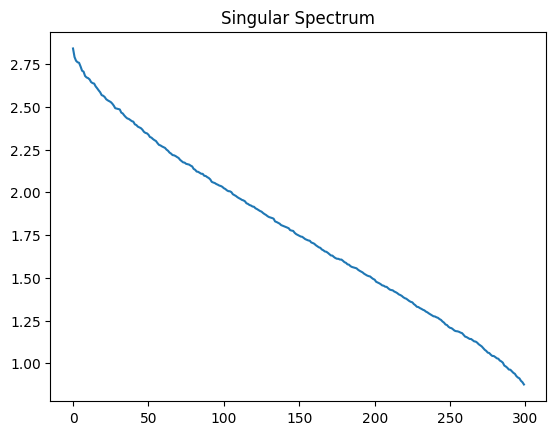

In [71]:
plt.plot(W)
plt.title("Singular Spectrum")

The minimization threshold $\epsilon$ is defined as $\epsilon^2 = \sigma^2(n + \lambda*\sqrt{2n})$

In [5]:
def compute_epsilon(n=300, lammy=2, sigma=0.05):
    epsilon = np.sqrt(sigma**2 * (n + lammy * np.sqrt(2 * n)))
    return epsilon

The paper generated the signals by choosing 50 indicies uniformly at random and setting the values of said indicies to $\pm 1$. The code below generates the signal by following the described process.

In [6]:
def gen_signal(components=50, m=1024):
    rand_indicies = np.random.choice(m, components)
    signal = np.zeros(1024)
    for idx in rand_indicies:
        temp = np.random.rand()
        if temp > 0.5:
            signal[idx] = 1
        else:
            signal[idx] = -1
    return signal    

Gaussian white noise $e \sim \mathcal{N}(0,~\sigma^2)$ is generated according to the code below.

In [7]:
def create_noise(n=300, sigma=0.05):
    noise = sigma * np.random.randn(n)
    return noise

We are solving the following minimization problem for Basis Pursuit:  
$\text{min } \lVert x \rVert_{\ell_1} \text{ subject to } \lVert Ax - y \rVert_{\ell_2} \leq \epsilon$  
where $x$ is the recovered signal, $y = Ax_0$, and $\epsilon$ is defined as described previously. 


As for Basis Pursuit De-Noising,
$y$ is redefined as $y = Ax_0 + e$, where the error equals $e \sim \mathcal{N}(0,~\sigma^2)$.
Therefore we have  
$\text{min } \lVert x \rVert_{\ell_1} \text{ subject to } \lVert Ax - (Ax_0 + e) \rVert_{\ell_2} \leq \epsilon$  

The following function implements Basis Pursuit and Basis Pursuit De-Noising based on these equations above using the cvxpy library.

In [8]:
def minimize(A, signal, epsilon, noise, add_noise, m=1024):
    x = cp.Variable(m)
    objective = cp.Minimize(cp.norm(x, 1))
    if (add_noise):
        constraints = [cp.norm((A @ x) - (A @ signal + noise)) <= epsilon]
    else:
        constraints = [cp.norm((A @ x) - (A @ signal)) <= epsilon]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    
    return x.value

In [9]:
def plot(signal, recovered, titles):
    fig, ax = plt.subplots(3, 1, figsize=(10,12))
    ax[0].plot(signal)
    ax[0].title.set_text(titles[0])
    ax[0].set_ylim([-1, 1])

    ax[1].plot(recovered)
    ax[1].title.set_text(titles[1])
    ax[1].set_ylim([-1, 1])

    ax[2].plot(signal - recovered)
    ax[2].title.set_text(titles[2])
    ax[2].set_ylim([-1, 1])
    
    print("L2 Error: ", np.linalg.norm(recovered - signal))

In [10]:
signal = gen_signal()
epsilon = compute_epsilon()
noise = create_noise()

## Sample Output

### Basis Pursuit

L2 Error:  8.592083684026678e-11


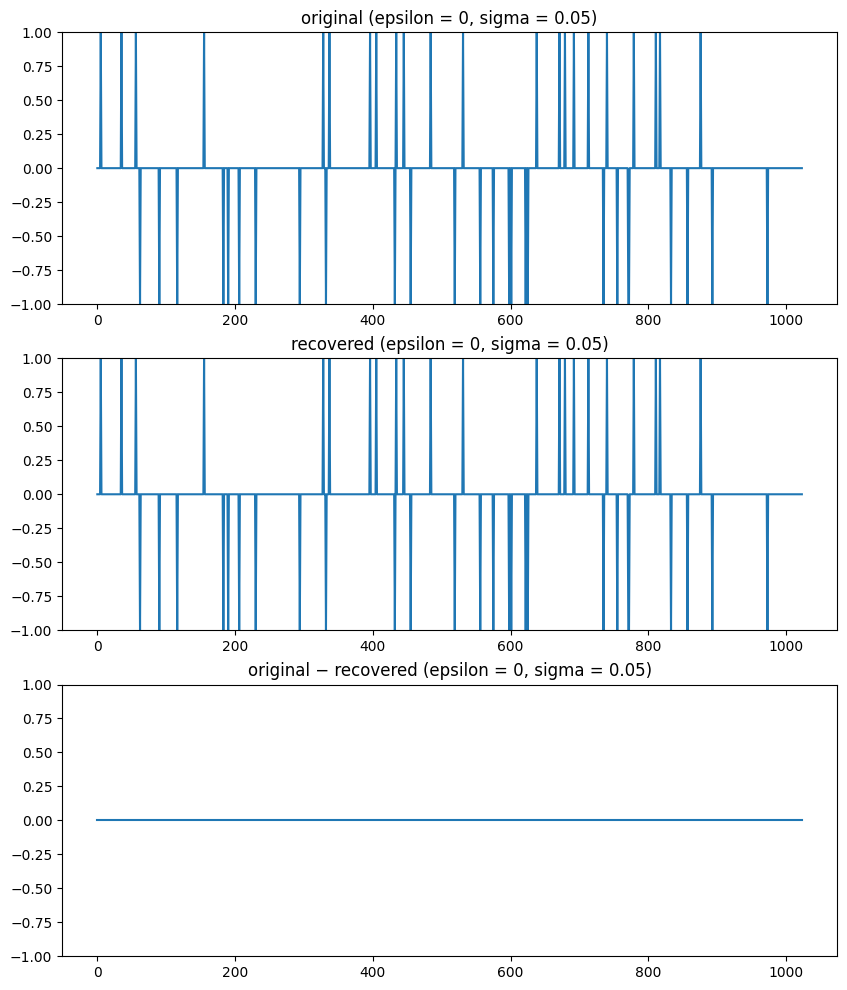

In [88]:
recovered = minimize(A, signal, 0, noise, 0)
plot(signal, recovered, ["original (epsilon = 0, sigma = 0.05)", 
                         "recovered (epsilon = 0, sigma = 0.05)", 
                         "original − recovered (epsilon = 0, sigma = 0.05)"])

By setting the error term to 0, basis pursuit seems to be able to recover the input signal (almost) perfectly (the remaining difference is likely due to rounding/floating point errors).

### Basis Pursuit with $\text{singular spectrum} = e^{-\frac{k}{100}}$

L2 Error:  9.587878754298351e-09


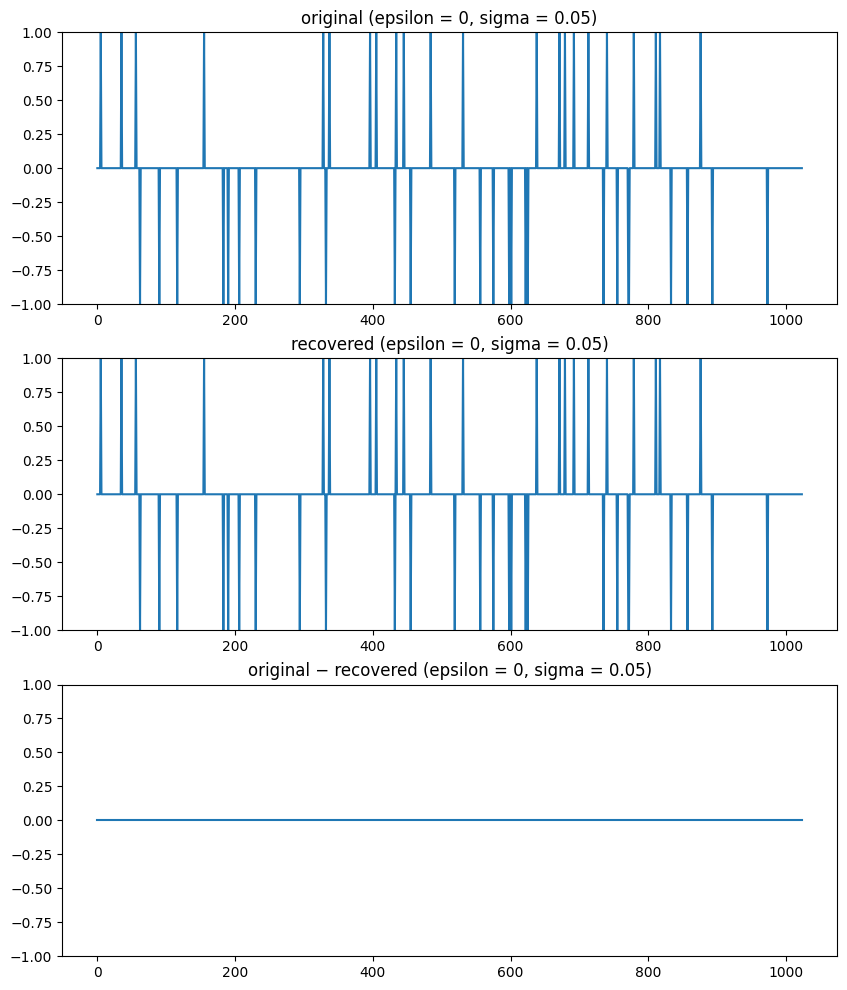

In [89]:
recovered = minimize(A_alt, signal, 0, noise, 0)
plot(signal, recovered, ["original (epsilon = 0, sigma = 0.05)", 
                         "recovered (epsilon = 0, sigma = 0.05)", 
                         "original − recovered (epsilon = 0, sigma = 0.05)"])

Basis pursuit with $\text{singular spectrum}= e^{-\frac{k}{100}}$ seems to be able to recover the input signal (almost) perfectly as well (the remaining difference is likely due to rounding/floating point errors). Although the L2 error is 2 orders of magnitude larger, the difference could be considered marginal in this example.

### Basis Pursuit De-Noising

L2 Error:  1.5691481706178307


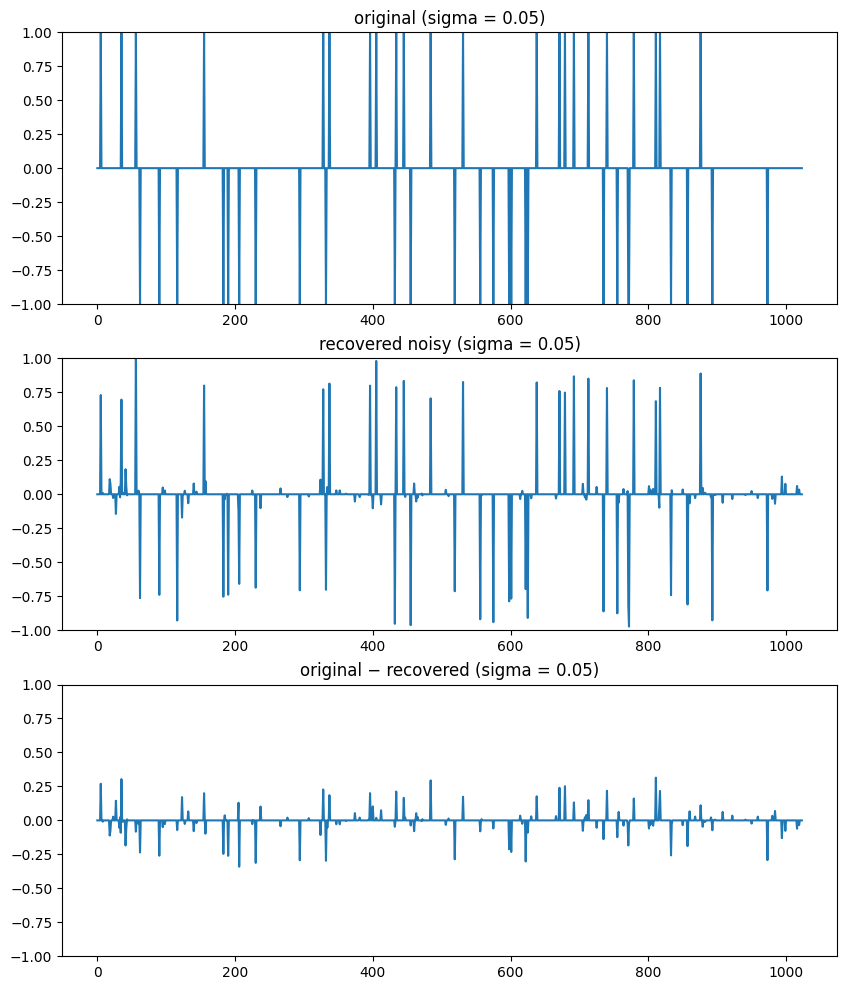

In [90]:
recovered = minimize(A, signal, epsilon, noise, 1)
plot(signal, recovered, ["original (sigma = 0.05)", 
                         "recovered noisy (sigma = 0.05)", 
                         "original − recovered (sigma = 0.05)"])

Basis pursuit de-noising seems to have recovered the signal from noise added observations fairly adequately. Although it is worth noting that the de-noised result is slightly worse than the sample presented in the paper, as the L2 error for sigma = 0.05 was 1.33, compared to the 1.57 reported in the example above. This discrepancy is most likely a result of the difference in RNG provided that other parameters and implementation details are fully consistent. 

### Basis Pursuit De-Noising with $\text{singular spectrum} = e^{-\frac{k}{100}}$

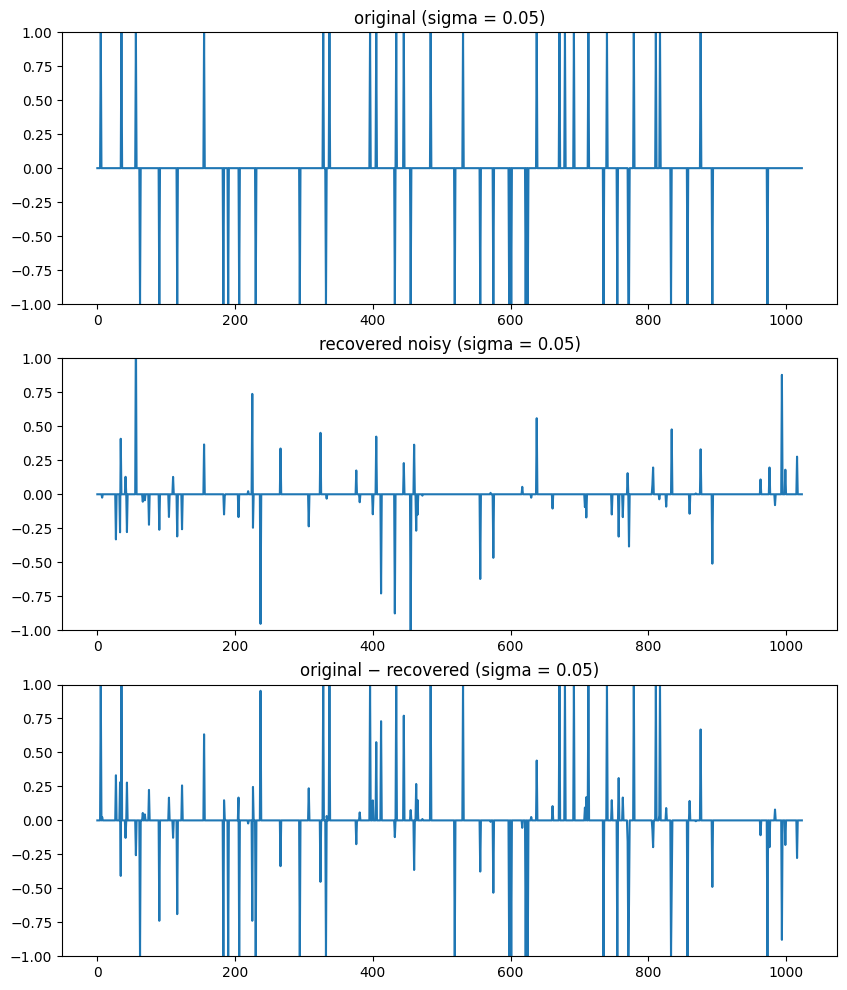

In [80]:
recovered = minimize(A_alt, signal, epsilon, noise, 1)
plot(signal, recovered, ["original (sigma = 0.05)", 
                         "recovered noisy (sigma = 0.05)", 
                         "original − recovered (sigma = 0.05)"])

With $\text{singular spectrum} = e^{-\frac{k}{100}}$, basis pursuit de-noising can no longer recover the signal from noisy data. As shown in the sample output above, the recovered signal no longer resembles the original signal.